In [13]:
ENV["PYTHON"] = "/Users/jluke/miniforge3/bin/python"
using Pkg;
Pkg.build("PyCall");

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/915ebe6f0e7302693bdd8eac985797dba1d25662/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`


In [15]:
Pkg.build("PyPlot");

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/915ebe6f0e7302693bdd8eac985797dba1d25662/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`


In [1]:
import Pkg;
Pkg.add("Distributions");

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [1]:
using DifferentialEquations

In [2]:
module atom_class

export cesiumAtom, Energy, getSaturationIntensity, getTransitionRate, atomInterface, getw0

using PyCall
np = pyimport("numpy")
arc = pyimport("arc")

struct atomInterface
    atom
end
function findStates(Atom::atomInterface, States, F::T, mF::T)::Float64 where {T<:AbstractFloat}
    ind = findall(States[2] .== F .&& States[3] .== mF)
    if length(ind) != 1
        return "Error"
    end
    Energy::Matrix{Float64} = States[1]
    return Energy[ind][1]
end

function Energy(Atom::atomInterface, n::T, l::T, j::G, f::G, mF::G, B::G) where {T<:Integer,G<:AbstractFloat}
    ev2Hz = 2.417989242E14
    States = Atom.atom.breitRabi(n, l, j, np.array([B]))
    return findStates(Atom, States, f, mF) + Atom.atom.getEnergy(n, l, j) * ev2Hz
end
function getw0(Atom::atomInterface, stateI::T, stateF::T, B) where {T}
    return Energy(Atom, stateF..., B) - Energy(Atom, stateI..., B)
end
function getSaturationIntensity(Atom::atomInterface, stateI::T, stateF::T) where {T}
    return Atom.atom.getSaturationIntensity(stateI..., stateF...)
end
function getTransitionRate(Atom::atomInterface, stateI::T, stateF::T) where {T}
    return Atom.atom.getTransitionRate(stateF[1:3]..., stateI[1:3]...)
end

Energy(Atom::atomInterface, n::T, l::T, j, f::T, mF::T, B::T) where {T<:Integer} = Energy(Atom, n, l, float(j), float(f), float(mF), float(B))
Energy(Atom::atomInterface, n::T, l::T, j::G, f::T, mF::T, B::G) where {G<:AbstractFloat,T<:Integer} = Energy(Atom, n, l, float(j), float(f), float(mF), float(B))

cesium = arc.Cesium


const cesium_a = cesium()

const cesiumAtom = atomInterface(cesium_a)

end


Main.atom_class

In [3]:
module utils
using LinearAlgebra
using Random
using Statistics
using Distributions

export pol_v, decompose_spherical, project_onto_vector, project_onto_plane, rotation_matrix, get_angle, getSphereVec

const pol_v = Dict("sigma_p" => -1 / sqrt(2) * ComplexF64[1, 1im, 0], "sigma_m" => 1 / sqrt(2) * ComplexF64[1, -1im, 0], "pi" => ComplexF64[0, 0, 1])


function decompose_spherical(pol)
    return ComplexF64[dot(conj(pol_v["pi"]), pol), dot(conj(pol_v["sigma_p"]), pol), dot(conj(pol_v["sigma_m"]), pol)]
end

project_onto_vector(v, n) = dot(v, n / norm(n)) * (n / norm(n))
project_onto_plane(x, n) = x - dot(x, n / norm(n)) * (n / norm(n))


function rotation_matrix(axis, theta)
    axis = axis / norm(axis)
    a = cos(theta / 2)
    b, c, d = -axis * sin(theta / 2)
    return [a*a+b*b-c*c-d*d 2*(b*c-a*d) 2*(b*d+a*c)
        2*(b*c+a*d) a*a+c*c-b*b-d*d 2*(c*d-a*b)
        2*(b*d-a*c) 2*(c*d+a*b) a*a+d*d-b*b-c*c]
end

get_angle(v1, v2) = acos(dot(v1, v2) / (norm(v1) * norm(v2)))

function getSphereVec(n)
    uvec = rand(Normal(), n)
    uvec = uvec / norm(uvec)
    return uvec
end

end

Main.utils

In [4]:
module BeamClass
using ..utils
using LinearAlgebra
export BeamProperties, GaussianBeam, get_Intensity

struct BeamProperties{T}
    Loc::T
    dir::T
    pol
    waist::Float64
    zr::Float64
end

BeamProperties(Loc::T, dir::T, pol) where {T} = BeamProperties{T}(Loc, dir, pol, 1e10, 1e10)
struct GaussianBeam
    beamStruct::BeamProperties
    I0::Float64
    waist::Float64
end

function get_Intensity(Beam::GaussianBeam, pos)
    BP = Beam.beamStruct
    r = norm(project_onto_plane(pos, BP.dir))
    z = norm(project_onto_vector(pos, BP.dir) - BP.Loc)
    w(z_i) = BP.waist * sqrt(1 + (z_i / BP.zr)^2)
    I = Beam.I0 * (BP.waist / w(z))^2 * exp(-2 * r^2 / (w(r)^2))
    return I
end

end

Main.BeamClass

In [5]:
module Consts
export C
const C = Dict("c" => 2.99798458E8, "hbar" => 1.054571E-34, "kb" => 1.3806452E-23, "e0" => 8.85418E-12, "q_c" => 1.60217663e-19, "m_e" => 9.11e-31)
end

Main.Consts

In [6]:
module CoolTrap
using ..BeamClass
using ..utils
using Interpolations

using LinearAlgebra
using Statistics: mean, std
using Distributions

using ..atom_class
using ..Consts

export MOT_Beam, get_Fnet, Tweezer, Tweezer_WF, generateAtoms, sampleVelocities_BD, Environment_T, get_Fnet_S

struct Environment_T
    Intensity
    B_Field
    grid
end



# MOT FUNCTIONS
struct MOT_Beam{T}
    ω0::T
    detuning::T
    k_vec::Vector{T}
    Γ::T
    Isat::T
    Beam::GaussianBeam
    s0
    environment
    dir
end

function MOT_Beam(Atom::atomInterface, Beam::BeamProperties, environment, stateI, stateF, detuning, I, updateS0=true)
    B_Field_func = environment.B_Field


    ω0 = 2 * pi * getw0(Atom, stateI, stateF, norm(B_Field_func(0, 0, 0)))
    BeamGaussian = GaussianBeam(Beam, I, ω0 + detuning)

    wavelength = C["c"] / (ω0 / (2 * pi))
    k_vec = 2 * pi / wavelength * Beam.dir
    Γ = getTransitionRate(Atom, stateI, stateF)
    Isat = getSaturationIntensity(Atom, stateI, stateF)
    q = stateF[end] - stateI[end]

    rot_mat(pos) = rotation_matrix(cross(B_Field_func(pos...), Beam.dir), get_angle(B_Field_func(pos...), Beam.dir))
    rotated_pol(pos) = rot_mat(pos) * Beam.pol
    decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))
    s0 = pos -> 0

    if !updateS0
        println("Fixing")
        setpoint = get_Intensity(BeamGaussian, [0.0, 0.0, 0.0]) / Isat * abs(decomposed_pol([0.0, 0.0, 0.0])[q >= 0 ? q + 1 : end + 1 + q])^2 / norm(decomposed_pol([0.0, 0.0, 0.0]))^2
        s0 = pos -> setpoint
    else
        println("Dynamic")
        s0 = pos -> get_Intensity(BeamGaussian, pos) / Isat * abs(decomposed_pol(pos)[q >= 0 ? q + 1 : end + 1 + q])^2 / norm(decomposed_pol(pos))^2
    end

    return MOT_Beam(ω0, detuning, k_vec, Γ, Isat, BeamGaussian, s0, environment, Beam.dir)
end



function get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel, detuningOffset)
    return MBeam.s0(pos) * MBeam.Γ / 2 * 1 / (1 + MBeam.s0(pos) + (2 * (MBeam.detuning + detuningOffset + dot(MBeam.k_vec, vel)) / MBeam.Γ)^2)
end
function get_scatteringrate(MBeam::MOT_Beam, pos, detuningOffset)
    return MBeam.s0(pos) * MBeam.Γ / 2 * 1 / (1 + MBeam.s0(pos) + (2 * (MBeam.detuning + detuningOffset) / MBeam.Γ)^2)
end
function get_Fabs(MBeam::MOT_Beam, pos, vel, detuningOffset)
    return C["hbar"] * (MBeam.ω0 + MBeam.detuning) / C["c"] * get_scatteringrate_abs(MBeam, pos, vel, detuningOffset) * MBeam.dir
end
function get_Fspon(MBeam::MOT_Beam, pos, detuningOffset)
    return C["hbar"] * norm(MBeam.k_vec) * get_scatteringrate(MBeam, pos, detuningOffset) * getSphereVec(3)
end
function get_Fnet(MBeam::MOT_Beam, pos, vel, detuningFunc::Any)
    detuningOffset = detuningFunc(pos...)
    Spont = get_Fspon(MBeam, pos, detuningOffset)
    Abs = get_Fabs(MBeam, pos, vel, detuningOffset)
    return Abs + Spont
end

get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel) = get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel, 0)
get_scatteringrate(MBeam::MOT_Beam, pos) = get_scatteringrate(MBeam::MOT_Beam, pos, 0)
get_Fabs(MBeam::MOT_Beam, pos, vel) = get_Fabs(MBeam::MOT_Beam, pos, vel, 0)
get_Fspon(MBeam::MOT_Beam, pos) = get_Fspon(MBeam::MOT_Beam, pos, 0)
get_Fnet(MBeam::MOT_Beam, pos, vel) = get_Fnet(MBeam::MOT_Beam, pos, vel, 0)




function get_Fnet(MBeam::MOT_Beam, pos, vel, detuningOffset::Number) 
    Spont = get_Fspon(MBeam, pos, detuningOffset)
    Abs = get_Fabs(MBeam, pos, vel, detuningOffset)
    return Abs + Spont
end


get_Fnet_S(MBeam::MOT_Beam, pos, vel, detuningFunc::Any) = vcat(get_Fnet(MBeam, pos, vel, detuningFunc), [get_scatteringrate(MBeam, pos, detuningFunc(pos...))])
get_Fnet_S(MBeam::MOT_Beam, pos, vel, detuningNum::Number) = vcat(get_Fnet(MBeam, pos, vel, detuningNum), [get_scatteringrate(MBeam, pos,detuningNum)])



abstract type AbstractTweezer end

# Tweezer Function 
struct Tweezer{T} <: AbstractTweezer
    trapR::T
    trapZ::T
    Beam::GaussianBeam
    ω0::T
    I0::T
    mass::T
    α
end

struct Tweezer_WF{T} <: AbstractTweezer
    trapR::T
    trapZ::T
    Beam::GaussianBeam
    mass::T
    ForceInterp
    α
end

function np_gradient(f::AbstractArray{T,N}; h=1.0) where {T,N}
    g = ntuple(N) do dim
        grad = similar(f)
        ax = axes(f, dim)
        # forward difference on the left boundary
        I1 = first(ax)
        I2 = I1 + 1
        for I in CartesianIndices(axes(f))
            if I[dim] < size(f, dim)
                grad[I] = (f[I + CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))] - f[I]) / h
            end
        end
        # central difference in the interior points
        for i in ax[2:end-1]
            I1 = i - 1
            I2 = i + 1
            for I in CartesianIndices(axes(f))
                if I[dim] > 1 && I[dim] < size(f, dim)
                    grad[I] = (f[I + CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))] - f[I - CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))]) / (2h)
                end
            end
        end
        # backward difference on the right boundary
        I1 = last(ax) - 1
        I2 = last(ax)
        for I in CartesianIndices(axes(f))
            if I[dim] > 1
                grad[I] = (f[I] - f[I - CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))]) / h
            end
        end
        grad
    end
    g
end

function Tweezer(Atom::atomInterface, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    mass = Atom.atom.mass

    waist = trapR / trapZ * (1 / (pi * sqrt(2))) * wavelength_tweezer
    zr = pi * waist^2 / wavelength_tweezer
    U0 = 1 / 4 * mass * waist^2 * trapR^2
    Damping_rate = Atom.atom.getTransitionRate(stateI..., stateF...)
    wavelength_transition = abs(Atom.atom.getTransitionWavelength(stateI..., stateF...))
    ω0 = C["c"] / wavelength_transition
    ω = C["c"] / wavelength_tweezer

    α = 6 * pi * C["e0"] * C["c"]^3 * (Damping_rate / ω0^2) / (ω0^2 - ω^2 - 1im * (ω^3 / ω0^2) * Damping_rate)
    I0 = U0 * 2 * C["e0"] * C["c"] / real(α)

    Beam = BeamProperties(Beam.Loc, Beam.dir, Beam.pol, waist, zr)
    BeamGaussian = GaussianBeam(Beam, I0, ω)

    return Tweezer(trapR, trapZ, BeamGaussian, ω0, I0, mass, α)
end


function Tweezer(Atom::atomInterface, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapDepth)
    mass = Atom.atom.mass

#    trapR= 

    waist = trapR / trapZ * (1 / (pi * sqrt(2))) * wavelength_tweezer
    zr = pi * waist^2 / wavelength_tweezer
    U0 = 1 / 4 * mass * BeamProperties.waist^2 * trapR^2
    Damping_rate = Atom.atom.getTransitionRate(stateI..., stateF...)
    wavelength_transition = abs(Atom.atom.getTransitionWavelength(stateI..., stateF...))
    ω0 = C["c"] / wavelength_transition
    ω = C["c"] / wavelength_tweezer

    α = 6 * pi * C["e0"] * C["c"]^3 * (Damping_rate / ω0^2) / (ω0^2 - ω^2 - 1im * (ω^3 / ω0^2) * Damping_rate)
    I0 = U0 * 2 * C["e0"] * C["c"] / real(α)

    Beam = BeamProperties(Beam.Loc, Beam.dir, Beam.pol, waist, zr)
    BeamGaussian = GaussianBeam(Beam, I0, ω)

    return Tweezer(trapR, trapZ, BeamGaussian, ω0, I0, mass, α)
end

function Tweezer_WF(BeamT::Tweezer, env::Environment_T, dl=1e-11)
    grid = env.grid
    PointGrid = ([i for i in Iterators.product(grid...)])
    Intensity = [get_Intensity(BeamT.Beam, [PointGrid[i, j, k]...]) for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid, 3)]
    push!(env.Intensity, Intensity)

    itp = interpolate(grid, Intensity, Gridded(Linear()))
    #ForceInterp(x, y, z) = 1 / (2 * C["e0"] * C["c"]) * real(BeamT.α) * [(itp[x-dl, y, z] + itp[x+dl, y, z]) / (2 * dl), (itp[x, y-dl, z] + itp[x, y+dl, z]) / (2 * dl), (itp[x, y, z-dl] + itp[x, y, z+dl]) / (2 * dl)]
    Ix, Iy, Iz = np_gradient(Intensity)
    Ix = interpolate(grid, Ix, Gridded(Linear()))
    Iy = interpolate(grid, Iy, Gridded(Linear()))
    Iz = interpolate(grid, Iz, Gridded(Linear()))
    ForceInterp(x, y, z) = 1 / (2 * C["e0"] * C["c"]*step(grid[1]))* real(BeamT.α) * [Ix[x, y, z], Iy[x, y, z], Iz[x, y, z]]
    return Tweezer_WF(BeamT.trapR, BeamT.trapZ, BeamT.Beam, BeamT.mass, ForceInterp, BeamT.α)
end


function generateAtoms(TBeam::T, Temp, atomNum) where {T<:AbstractTweezer}
    coordList = []

    sigmaR = 1 / TBeam.trapR * sqrt(C["kb"] * Temp / TBeam.mass)
    sigmaZ = 1 / TBeam.trapZ * sqrt(C["kb"] * Ttemp / TBeam.mass)
    coordZ = rand(Normal(0, sigmaZ), AtomNum)
    coordR = rand(Normal(0, sigmaR), AtomNum)
    Beam_Dir = TBeam.Beam.beamStruct.dir
    Beam_Pos = TBeam.Beam.beamStruct.Loc
    for i in 1:AtomNum
        x, y = coordR[i] * getSphereVec(2)
        z = coordZ[i]
        coord = [x, y, z]
        if !(Beam_Dir == [0, 0, 1])
            Rot = rotation_matrix(cross([0, 0, 1], Beam_Dir), get_angle([0, 0, 1], Beam_Dir))
            coord = Rot * coord
        end

        push!(coordList, coord + Beam_Pos)
    end
    return coordList
end


function sampleVelocities_BD(TBeam::T, Temp, atomNum) where {T<:AbstractTweezer} #check 
    scale = sqrt(C["kb"] * T / TBeam.mass)
    vx, vy, vz = randn(num_particles) * a_Rb, randn(num_particles) * a_Rb, randn(num_particles) * a_Rb
    velList = []
    for i in 1:atomNum
        push!(velList, [vx[i], vy[i], vz[i]])
    end
    return velList
end


function get_Fnet(TBeam::Tweezer_WF, pos, vel)
    return TBeam.ForceInterp(pos...)
end


function get_Fnet(TBeam::Tweezer_WF, pos, vel, rand::Any)
    return TBeam.ForceInterp(pos...)
end
get_Fnet_S(TBeam::Tweezer_WF, pos, vel, rand::Any) = vcat(get_Fnet(TBeam::Tweezer_WF, pos, vel, rand::Any), [0.0])

end

Main.CoolTrap

In [ ]:
reload(Atom)

In [7]:
module SystemSetup

using ..CoolTrap
using ..atom_class
using ..BeamClass

export System, set_tweezer, set_MOT, set_tweezer, join_Beams, clear_beams, set_SystemRHS, set_SystemRHS_Photons

mutable struct System
    AtomType
    TweezerConfig
    MOTConfig
    BeamConfig
    Environment
end

function System(Atom::atomInterface, magneticField, gridBounds)
    return System(Atom, [], [], [], Environment_T([], magneticField, (gridBounds, gridBounds, gridBounds)))
end

function set_tweezer(Sys::System, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    gridbounds = Sys.Environment.grid[1]
    spacing = gridbounds[2] - gridbounds[1]
    TweezerP = Tweezer(Sys.AtomType, Beam, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    TweezerA = Tweezer_WF(TweezerP, Sys.Environment, spacing )
    push!(Sys.TweezerConfig, TweezerA)
    push!(Sys.BeamConfig, TweezerA)
end
function set_MOT(Sys::System, Beam::BeamProperties, stateI, stateF, detuning, I, update=true)
    MOT_i = MOT_Beam(Sys.AtomType, Beam, Sys.Environment, stateI, stateF, detuning, I, update)
    push!(Sys.MOTConfig, MOT_i)
    push!(Sys.BeamConfig, MOT_i)
end


function clear_beams(Sys::System)
    System.TweezerConfig = []
    System.MOTConfig = []
    System.BeamConfig = []
end

function set_SystemRHS(Sys::System)
    function RHS(dy, y, p, t)
        #pos_vec = y[1:3]
        #vel_vec = y[4:6]
        dy[1:3] = y[4:6]
        dy[4:6] = zeros(3)
        for beam in Sys.BeamConfig
            #Fnet_i = get_Fnet(beam, y[1:3], y[4:6])
            dy[4:6] .+= get_Fnet(beam, y[1:3], y[4:6], p[1])# Fnet_i
        end
        dy[4:6] = dy[4:6] / Sys.AtomType.atom.mass
    end
    return RHS
end
function set_SystemRHS_Photons(Sys::System)
    function RHS(dy, y, p, t)
        #pos_vec = y[1:3]
        #vel_vec = y[4:6]
        dy[1:3] = y[4:6]
        dy[4:end] = zeros(length(y[4:end]))
        for beam in Sys.BeamConfig
            #Fnet_i = get_Fnet(beam, y[1:3], y[4:6])
            dy[4:end] .+= get_Fnet_S(beam, y[1:3], y[4:6], p[1])# Fnet_i
        end
        dy[4:6] = dy[4:6] / Sys.AtomType.atom.mass
    end
    return RHS
end


end

Main.SystemSetup

In [8]:
using ProfileView
using BenchmarkTools

In [8]:
GridRegion = OurSystem.Environment.grid
itp = interpolate(GridRegion,  OurSystem.Environment.Intensity[1], Gridded(Linear()))

I0 = itp(0, 0, 0)

detuning_func(x, y, z) = (itp(x, y, z)/I0 - 1)*107e6
pos = [4e-6, 4e-6, 4e-6]; #[0, 0, 0]
get_Fnet_S(OurSystem.MOTConfig[1], [0, 0, 0],  [0.0, 0.0, 0.0], detuning_func)

UndefVarError: UndefVarError: OurSystem not defined

In [67]:
1.1271274906144684e7/856468.1171712755

13.16018037352191

In [58]:
detuning_func(4e-6, 4e-6, 4e-6)

-1.06999994982959e8

# Setup of System

In [9]:
#Consts 
module Consts
export C
const C = Dict("c" => 2.99798458E8, "hbar" => 1.054571E-34, "kb" => 1.3806452E-23, "e0" => 8.85418E-12, "q_c" => 1.60217663e-19, "m_e" => 9.11e-31)
end
module atom_class

export cesiumAtom, Energy, getSaturationIntensity, getTransitionRate, atomInterface, getw0

using PyCall
np = pyimport("numpy")
arc = pyimport("arc")

struct atomInterface
    atom
end
function findStates(Atom::atomInterface, States, F::T, mF::T)::Float64 where {T<:AbstractFloat}
    ind = findall(States[2] .== F .&& States[3] .== mF)
    if length(ind) != 1
        return "Error"
    end
    Energy::Matrix{Float64} = States[1]
    return Energy[ind][1]
end

function Energy(Atom::atomInterface, n::T, l::T, j::G, f::G, mF::G, B::G) where {T<:Integer,G<:AbstractFloat}
    ev2Hz = 2.417989242E14
    States = Atom.atom.breitRabi(n, l, j, np.array([B]))
    return findStates(Atom, States, f, mF) + Atom.atom.getEnergy(n, l, j) * ev2Hz
end
function getw0(Atom::atomInterface, stateI::T, stateF::T, B) where {T}
    return Energy(Atom, stateF..., B) - Energy(Atom, stateI..., B)
end
function getSaturationIntensity(Atom::atomInterface, stateI::T, stateF::T) where {T}
    return Atom.atom.getSaturationIntensity(stateI..., stateF...)
end
function getTransitionRate(Atom::atomInterface, stateI::T, stateF::T) where {T}
    return Atom.atom.getTransitionRate(stateF[1:3]..., stateI[1:3]...)
end

function getLifetime(Atom::atomInterface, stateF)
    Atom.atom.getStateLifetime(stateF[1:3]...)
end


Energy(Atom::atomInterface, n::T, l::T, j, f::T, mF::T, B::T) where {T<:Integer} = Energy(Atom, n, l, float(j), float(f), float(mF), float(B))
Energy(Atom::atomInterface, n::T, l::T, j::G, f::T, mF::T, B::G) where {G<:AbstractFloat,T<:Integer} = Energy(Atom, n, l, float(j), float(f), float(mF), float(B))

cesium = arc.Cesium


const cesium_a = cesium()

const cesiumAtom = atomInterface(cesium_a)

end
# Utils 
module utils
using LinearAlgebra
using Random
using Statistics
using Distributions

export pol_v, decompose_spherical, project_onto_vector, project_onto_plane, rotation_matrix, get_angle, getSphereVec

const pol_v = Dict("sigma_p" => -1 / sqrt(2) * ComplexF64[1, 1im, 0], "sigma_m" => 1 / sqrt(2) * ComplexF64[1, -1im, 0], "pi" => ComplexF64[0, 0, 1])


function decompose_spherical(pol)
    return ComplexF64[dot(conj(pol_v["pi"]), pol), dot(conj(pol_v["sigma_p"]), pol), dot(conj(pol_v["sigma_m"]), pol)]
end

project_onto_vector(v, n) = dot(v, n / norm(n)) * (n / norm(n))
project_onto_plane(x, n) = x - dot(x, n / norm(n)) * (n / norm(n))


function rotation_matrix(axis, theta)
    axis = axis / norm(axis)
    a = cos(theta / 2)
    b, c, d = -axis * sin(theta / 2)
    return [a*a+b*b-c*c-d*d 2*(b*c-a*d) 2*(b*d+a*c)
        2*(b*c+a*d) a*a+c*c-b*b-d*d 2*(c*d-a*b)
        2*(b*d-a*c) 2*(c*d+a*b) a*a+d*d-b*b-c*c]
end

get_angle(v1, v2) = acos(dot(v1, v2) / (norm(v1) * norm(v2)))

function getSphereVec(n)
    uvec = rand(Normal(), n)
    uvec = uvec / norm(uvec)
    return uvec
end

end
# Beam Class 
module BeamClass
using ..utils
using LinearAlgebra
export BeamProperties, GaussianBeam, get_Intensity

struct BeamProperties{T}
    Loc::T
    dir::T
    pol
    waist::Float64
    zr::Float64
end

BeamProperties(Loc::T, dir::T, pol) where {T} = BeamProperties{T}(Loc, dir, pol, 1e10, 1e10)
struct GaussianBeam
    beamStruct::BeamProperties
    I0::Float64
    waist::Float64
end

function get_Intensity(Beam::GaussianBeam, pos)
    BP = Beam.beamStruct
    r = norm(project_onto_plane(pos, BP.dir))
    z = norm(project_onto_vector(pos, BP.dir) - BP.Loc)
    w(z_i) = BP.waist * sqrt(1 + (z_i / BP.zr)^2)
    I = Beam.I0 * (BP.waist / w(z))^2 * exp(-2 * r^2 / (w(r)^2))
    return I
end

end



###
module CoolTrap
using ..BeamClass
using ..utils
using Interpolations

using LinearAlgebra
using Statistics: mean, std
using Distributions

using ..atom_class
using ..Consts

export MOT_Beam, get_Fnet, Tweezer, Tweezer_WF, generateAtoms, sampleVelocities_BD, Environment_T, get_Fnet_S

struct Environment_T
    Intensity
    B_Field
    grid
end


mutable struct SpontEmission{T}
    const Γ_spont::T
    last_em::T
end

# MOT FUNCTIONS
struct MOT_Beam{T}
    ω0::T
    detuning::T
    k_vec::Vector{T}
    Γ::T
    SE::SpontEmission
    Isat::T
    Beam::GaussianBeam
    s0
    environment
    dir
end

function MOT_Beam(Atom::atomInterface, Beam::BeamProperties, environment, stateI, stateF, detuning, I, updateS0=true)
    B_Field_func = environment.B_Field


    ω0 = 2 * pi * getw0(Atom, stateI, stateF, norm(B_Field_func(0, 0, 0)))
    BeamGaussian = GaussianBeam(Beam, I, ω0 + detuning)

    wavelength = C["c"] / (ω0 / (2 * pi))
    k_vec = 2 * pi / wavelength * Beam.dir
    Γ = getTransitionRate(Atom, stateI, stateF)
    Γ_spont = 1/getLifetime(Atom, stateF)
    Isat = getSaturationIntensity(Atom, stateI, stateF)
    q = stateF[end] - stateI[end]

    rot_mat(pos) = rotation_matrix(cross(B_Field_func(pos...), Beam.dir), get_angle(B_Field_func(pos...), Beam.dir))
    rotated_pol(pos) = rot_mat(pos) * Beam.pol
    decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))
    s0 = pos -> 0

    if !updateS0
        println("Fixing")
        setpoint = get_Intensity(BeamGaussian, [0.0, 0.0, 0.0]) / Isat * abs(decomposed_pol([0.0, 0.0, 0.0])[q >= 0 ? q + 1 : end + 1 + q])^2 / norm(decomposed_pol([0.0, 0.0, 0.0]))^2
        s0 = pos -> setpoint
    else
        println("Dynamic")
        s0 = pos -> get_Intensity(BeamGaussian, pos) / Isat * abs(decomposed_pol(pos)[q >= 0 ? q + 1 : end + 1 + q])^2 / norm(decomposed_pol(pos))^2
    end

    return MOT_Beam(ω0, detuning, k_vec, Γ, SpontEmission(Γ_spont, 0.0),  Isat, BeamGaussian, s0, environment, Beam.dir)
end



function get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel, detuningOffset)
    return MBeam.s0(pos) * MBeam.Γ / 2 * 1 / (1 + MBeam.s0(pos) + (2 * (MBeam.detuning + detuningOffset + dot(MBeam.k_vec, vel)) / MBeam.Γ)^2)
end
function get_scatteringrate(MBeam::MOT_Beam, pos, detuningOffset)
    return MBeam.s0(pos) * MBeam.Γ / 2 * 1 / (1 + MBeam.s0(pos) + (2 * (MBeam.detuning + detuningOffset) / MBeam.Γ)^2)
end
function get_Fabs(MBeam::MOT_Beam, pos, vel, detuningOffset)
    return C["hbar"] * (MBeam.ω0 + MBeam.detuning) / C["c"] * get_scatteringrate_abs(MBeam, pos, vel, detuningOffset) * MBeam.dir
end
function get_momSpon(MBeam::MOT_Beam, t)
    if (t- MBeam.SE.last_em)*MBeam.SE.Γ_spont > rand()
        MBeam.SE.last_em = t
        return C["hbar"] * norm(MBeam.k_vec) * getSphereVec(3)
    else
        return zeros(Float64, 3)
    end
end
function get_Fnet(MBeam::MOT_Beam, pos, vel, detuningFunc::Any)
    detuningOffset = detuningFunc(pos...)
    #Spont = get_Fspon(MBeam, pos, detuningOffset)
    Abs = get_Fabs(MBeam, pos, vel, detuningOffset)
    return Abs #+ Spont
end

get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel) = get_scatteringrate_abs(MBeam::MOT_Beam, pos, vel, 0)
get_scatteringrate(MBeam::MOT_Beam, pos) = get_scatteringrate(MBeam::MOT_Beam, pos, 0)
get_Fabs(MBeam::MOT_Beam, pos, vel) = get_Fabs(MBeam::MOT_Beam, pos, vel, 0)
#get_Fspon(MBeam::MOT_Beam, pos) = get_Fspon(MBeam::MOT_Beam, pos, 0)
get_Fnet(MBeam::MOT_Beam, pos, vel) = get_Fnet(MBeam::MOT_Beam, pos, vel, 0)




function get_Fnet(MBeam::MOT_Beam, pos, vel, detuningOffset::Number) 
    Spont = get_Fspon(MBeam, pos, detuningOffset)
    Abs = get_Fabs(MBeam, pos, vel, detuningOffset)
    return Abs + Spont
end


get_Fnet_S(MBeam::MOT_Beam, pos, vel, detuningFunc::Any) = vcat(get_Fnet(MBeam, pos, vel, detuningFunc), [get_scatteringrate(MBeam, pos, detuningFunc(pos...))])
get_Fnet_S(MBeam::MOT_Beam, pos, vel, detuningNum::Number) = vcat(get_Fnet(MBeam, pos, vel, detuningNum), [get_scatteringrate(MBeam, pos,detuningNum)])



abstract type AbstractTweezer end

# Tweezer Function 
struct Tweezer{T} <: AbstractTweezer
    trapR::T
    trapZ::T
    Beam::GaussianBeam
    ω0::T
    I0::T
    mass::T
    α
end

struct Tweezer_WF{T} <: AbstractTweezer
    trapR::T
    trapZ::T
    Beam::GaussianBeam
    mass::T
    ForceInterp
    α
end

function np_gradient(f::AbstractArray{T,N}; h=1.0) where {T,N}
    g = ntuple(N) do dim
        grad = similar(f)
        ax = axes(f, dim)
        # forward difference on the left boundary
        I1 = first(ax)
        I2 = I1 + 1
        for I in CartesianIndices(axes(f))
            if I[dim] < size(f, dim)
                grad[I] = (f[I + CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))] - f[I]) / h
            end
        end
        # central difference in the interior points
        for i in ax[2:end-1]
            I1 = i - 1
            I2 = i + 1
            for I in CartesianIndices(axes(f))
                if I[dim] > 1 && I[dim] < size(f, dim)
                    grad[I] = (f[I + CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))] - f[I - CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))]) / (2h)
                end
            end
        end
        # backward difference on the right boundary
        I1 = last(ax) - 1
        I2 = last(ax)
        for I in CartesianIndices(axes(f))
            if I[dim] > 1
                grad[I] = (f[I] - f[I - CartesianIndex(ntuple(d -> d == dim ? 1 : 0, N))]) / h
            end
        end
        grad
    end
    g
end

function Tweezer(Atom::atomInterface, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    mass = Atom.atom.mass

    waist = trapR / trapZ * (1 / (pi * sqrt(2))) * wavelength_tweezer
    zr = pi * waist^2 / wavelength_tweezer
    U0 = 1 / 4 * mass * waist^2 * trapR^2
    Damping_rate = Atom.atom.getTransitionRate(stateI..., stateF...)
    wavelength_transition = abs(Atom.atom.getTransitionWavelength(stateI..., stateF...))
    ω0 = C["c"] / wavelength_transition
    ω = C["c"] / wavelength_tweezer

    α = 6 * pi * C["e0"] * C["c"]^3 * (Damping_rate / ω0^2) / (ω0^2 - ω^2 - 1im * (ω^3 / ω0^2) * Damping_rate)
    I0 = U0 * 2 * C["e0"] * C["c"] / real(α)

    Beam = BeamProperties(Beam.Loc, Beam.dir, Beam.pol, waist, zr)
    BeamGaussian = GaussianBeam(Beam, I0, ω)

    return Tweezer(trapR, trapZ, BeamGaussian, ω0, I0, mass, α)
end


function Tweezer(Atom::atomInterface, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapDepth)
    mass = Atom.atom.mass

#    trapR= 

    waist = trapR / trapZ * (1 / (pi * sqrt(2))) * wavelength_tweezer
    zr = pi * waist^2 / wavelength_tweezer
    U0 = 1 / 4 * mass * BeamProperties.waist^2 * trapR^2
    Damping_rate = Atom.atom.getTransitionRate(stateI..., stateF...)
    wavelength_transition = abs(Atom.atom.getTransitionWavelength(stateI..., stateF...))
    ω0 = C["c"] / wavelength_transition
    ω = C["c"] / wavelength_tweezer

    α = 6 * pi * C["e0"] * C["c"]^3 * (Damping_rate / ω0^2) / (ω0^2 - ω^2 - 1im * (ω^3 / ω0^2) * Damping_rate)
    I0 = U0 * 2 * C["e0"] * C["c"] / real(α)

    Beam = BeamProperties(Beam.Loc, Beam.dir, Beam.pol, waist, zr)
    BeamGaussian = GaussianBeam(Beam, I0, ω)

    return Tweezer(trapR, trapZ, BeamGaussian, ω0, I0, mass, α)
end

function Tweezer_WF(BeamT::Tweezer, env::Environment_T, dl=1e-11)
    grid = env.grid
    PointGrid = ([i for i in Iterators.product(grid...)])
    Intensity = [get_Intensity(BeamT.Beam, [PointGrid[i, j, k]...]) for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid, 3)]
    push!(env.Intensity, Intensity)

    itp = interpolate(grid, Intensity, Gridded(Linear()))
    #ForceInterp(x, y, z) = 1 / (2 * C["e0"] * C["c"]) * real(BeamT.α) * [(itp[x-dl, y, z] + itp[x+dl, y, z]) / (2 * dl), (itp[x, y-dl, z] + itp[x, y+dl, z]) / (2 * dl), (itp[x, y, z-dl] + itp[x, y, z+dl]) / (2 * dl)]
    Ix, Iy, Iz = np_gradient(Intensity)
    Ix = interpolate(grid, Ix, Gridded(Linear()))
    Iy = interpolate(grid, Iy, Gridded(Linear()))
    Iz = interpolate(grid, Iz, Gridded(Linear()))
    ForceInterp(x, y, z) = 1 / (2 * C["e0"] * C["c"]*step(grid[1]))* real(BeamT.α) * [Ix[x, y, z], Iy[x, y, z], Iz[x, y, z]]
    return Tweezer_WF(BeamT.trapR, BeamT.trapZ, BeamT.Beam, BeamT.mass, ForceInterp, BeamT.α)
end


function generateAtoms(TBeam::T, Temp, atomNum) where {T<:AbstractTweezer}
    coordList = []

    sigmaR = 1 / TBeam.trapR * sqrt(C["kb"] * Temp / TBeam.mass)
    sigmaZ = 1 / TBeam.trapZ * sqrt(C["kb"] * Temp / TBeam.mass)
    coordZ = rand(Normal(0, sigmaZ), atomNum)
    coordR = rand(Normal(0, sigmaR), atomNum)
    Beam_Dir = TBeam.Beam.beamStruct.dir
    Beam_Pos = TBeam.Beam.beamStruct.Loc
    for i in 1:atomNum
        x, y = coordR[i] * getSphereVec(2)
        z = coordZ[i]
        coord = [x, y, z]
        if !(Beam_Dir == [0, 0, 1])
            Rot = rotation_matrix(cross([0, 0, 1], Beam_Dir), get_angle([0, 0, 1], Beam_Dir))
            coord = Rot * coord
        end

        push!(coordList, coord + Beam_Pos)
    end
    return coordList
end


function sampleVelocities_BD(TBeam::T, Temp, atomNum) where {T<:AbstractTweezer} #check 
    scale = sqrt(C["kb"] * Temp / TBeam.mass)
    vx, vy, vz = randn(atomNum) * scale, randn(atomNum) * scale, randn(atomNum) * scale
    velList = []
    for i in 1:atomNum
        push!(velList, [vx[i], vy[i], vz[i]])
    end
    return velList
end


function get_Fnet(TBeam::Tweezer_WF, pos, vel)
    return TBeam.ForceInterp(pos...)
end


function get_Fnet(TBeam::Tweezer_WF, pos, vel, rand::Any)
    return TBeam.ForceInterp(pos...)
end
get_Fnet_S(TBeam::Tweezer_WF, pos, vel, rand::Any) = vcat(get_Fnet(TBeam::Tweezer_WF, pos, vel, rand::Any), [0.0])

end
###
module SystemSetup

using ..CoolTrap
using ..atom_class
using ..BeamClass

export System, set_tweezer, set_MOT, set_tweezer, join_Beams, clear_beams, set_SystemRHS, set_SystemRHS_Photons

mutable struct System
    AtomType
    TweezerConfig
    MOTConfig
    BeamConfig
    Environment
end

function System(Atom::atomInterface, magneticField, gridBounds)
    return System(Atom, [], [], [], Environment_T([], magneticField, (gridBounds, gridBounds, gridBounds)))
end

function set_tweezer(Sys::System, Beam::BeamProperties, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    gridbounds = Sys.Environment.grid[1]
    spacing = gridbounds[2] - gridbounds[1]
    TweezerP = Tweezer(Sys.AtomType, Beam, stateI, stateF, wavelength_tweezer, trapR, trapZ)
    TweezerA = Tweezer_WF(TweezerP, Sys.Environment, spacing )
    push!(Sys.TweezerConfig, TweezerA)
    push!(Sys.BeamConfig, TweezerA)
end
function set_MOT(Sys::System, Beam::BeamProperties, stateI, stateF, detuning, I, update=true)
    MOT_i = MOT_Beam(Sys.AtomType, Beam, Sys.Environment, stateI, stateF, detuning, I, update)
    push!(Sys.MOTConfig, MOT_i)
    push!(Sys.BeamConfig, MOT_i)
end


function clear_beams(Sys::System)
    System.TweezerConfig = []
    System.MOTConfig = []
    System.BeamConfig = []
end

function set_SystemRHS(Sys::System)
    function RHS(dy, y, p, t)
        #pos_vec = y[1:3]
        #vel_vec = y[4:6]
        dy[1:3] = y[4:6]
        dy[4:6] = zeros(3)
        for beam in Sys.BeamConfig
            #Fnet_i = get_Fnet(beam, y[1:3], y[4:6])
            dy[4:6] .+= get_Fnet(beam, y[1:3], y[4:6], p[1])# Fnet_i
        end
        dy[4:6] = dy[4:6] / Sys.AtomType.atom.mass
    end
    return RHS
end
function set_SystemRHS_Photons(Sys::System)
    function RHS(dy, y, p, t)

        dy[4:end] = zeros(length(y[4:end]))
        for beam in Sys.BeamConfig
            dy[4:end] .+= get_Fnet_S(beam, y[1:3], y[4:6], p[1])# Fnet_i
        end
        for beam in Sys.MOTConfig
            y[4:6] .+= get_momSpon(beam)
        end
        dy[1:3] = y[4:6]
        dy[4:6] = dy[4:6] / Sys.AtomType.atom.mass
    end
    return RHS
end


end

Main.SystemSetup

In [34]:
boundMin, boundMax = minimum(OurSystem.Environment.grid[1]), maximum(OurSystem.Environment.grid[1])

(-1.5e-5, 1.5e-5)

In [2]:
using DifferentialEquations

In [10]:
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap

function createSystem()
    BField(x, y, z) = 800E-4 * [0, 0, 1]
    atomType = cesiumAtom
    OurSystem = System(atomType, BField, -4e-6:0.4e-7:4e-6)
    return OurSystem
end
function createLight!(OurSystem)
    #clear_beams(OurSystem)
    stateF = (6, 1, 1.5, 5, 5)
    stateI = (6, 0, 0.5, 4, 4)
    detuning = 3e6
    I_mot = 14
    beamAngle = 45 * pi / 180


    println("Setting up MOT")
    updates0 = false
    LocAll::Vector{Float64} = [0, 0, 0]
    #set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R1
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot,updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)
    #R2
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, -sin(beamAngle), cos(beamAngle)], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot, updates0)
    #set_MOT(OurSystem, BeamProperties(LocAll, [0, sin(beamAngle), -cos(beamAngle)], pol_v["sigma_p"]),  stateI, stateF, detuning, I_mot, updates0)

    println("Setting up Tweezer")

    #Tweezer
    stateI_T = (6, 1, 1 / 2)
    stateF_T = (6, 0, 1 / 2)
    wavelength_tweezer = 1064E-9
    trapR, trapZ = 2 * pi * 0.150e6, 2 * pi * 0.029e6

    set_tweezer(OurSystem, BeamProperties(LocAll, [0.0, 0.0, 1.0], pol_v["pi"]), stateI_T, stateF_T, wavelength_tweezer, trapR, trapZ)
    #join_Beams(OurSystem)
end

OurSystem = createSystem()
createLight!(OurSystem);


Setting up MOT
Setting up Tweezer


In [6]:
using Interpolations
function simulate(Sys::System)
    RHS = set_SystemRHS_Photons(Sys)

    boundMin, boundMax = minimum(OurSystem.Environment.grid[1]), maximum(OurSystem.Environment.grid[1])
    conditionStop(y, t, integrator) = !any(boundMin + 1e-6 .< y[1:3]) || !any(y[1:3] .< boundMax - 1e-6)
    affect!(integrator) = terminate!(integrator)
    cb = DiscreteCallback(conditionStop, affect!)


    #GridRegion = Sys.Environment.grid
    #itp = interpolate(GridRegion,  Sys.Environment.Intensity[1], Gridded(Linear()))
    
    #I0 = itp(0, 0, 0)

    detuning_func(x, y, z) = #(itp(x, y, z)/I0 - 1)*107e6

    p = [detuning_func] 
    u0 = zeros(Float64, 7)
    u0[1:6] = 0.025011808599180355
    tspan = (0, 10e-3)
    prob = ODEProblem(RHS, u0, tspan, p)
    dt = 5e-9
    sol = solve(prob, RK4(), dt=dt, adaptive=false)#, callback=cb, abstol=1e-3, reltol=1e-3)
    return sol.t, hcat(sol.u...)
end

simulate (generic function with 1 method)

In [11]:
using .Consts
TBeam = OurSystem.TweezerConfig[1]
#generateAtoms(TBeam, 1e-6, 1)
sampleVelocities_BD(TBeam, 1e-6, 1) 




UndefVarError: UndefVarError: a_Rb not defined

In [7]:
t, u = simulate(OurSystem)
x, y, z, vx, vy, vz = u[1, :],  u[2, :],  u[3, :],  u[4, :], u[5, :], u[6, :];

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [6]:
using DifferentialEquations

In [26]:
nPhotons = u[7, :];
println(maximum(nPhotons))

77417.87218968972


In [10]:
using PyPlot

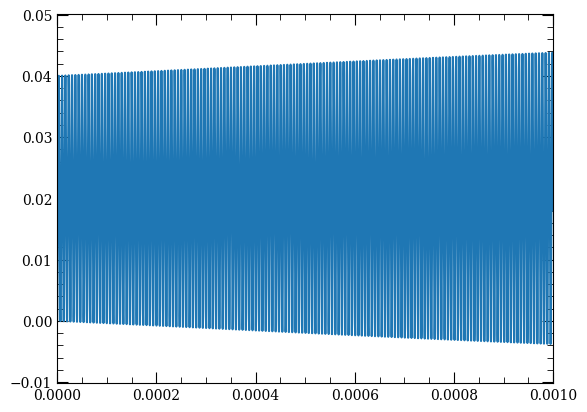

In [40]:

fig = plt.figure()
plot(t, y*1e6)
xlim([0, 1e-3])
fig


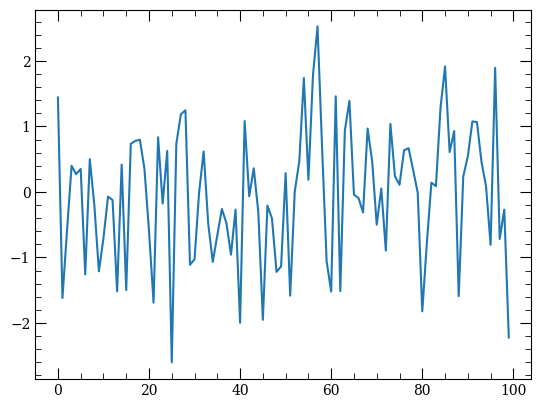

In [22]:
using PyPlot
pygui(true)

plot(randn(100))
fig = plt.figure()
plot(randn(100))
fig

In [32]:
using PyCall
plt = pyimport("matplotlib.pyplot")

PyObject <module 'matplotlib.pyplot' from '/Users/jluke/miniforge3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [43]:
plt.plot(t, z)
plt.show()

In [11]:
using DifferentialEquations

In [27]:
min_, max_ = 1, 3
d = [1, 2, 3]
any(min_ .< d .< max_)

true

In [10]:
using DifferentialEquations

function f(du, u, p, t)
    du[1] = u[1]
    du[2] = u[2]
end

threshold = 10
u0 = [1.0, 1.0]
tspan = (0.0, 2.0)
prob = ODEProblem(f, u0, tspan)

condition(u, t, integrator) = u[1] > threshold
affect!(integrator) = terminate!(integrator)      # How to respond to the event
cb = DiscreteCallback(condition, affect!)

dt = 0.1
sol = solve(prob, Euler(), dt=dt, callback=cb)

println(sol.u)


[[1.0, 1.0], [1.1, 1.1], [1.2100000000000002, 1.2100000000000002], [1.3310000000000002, 1.3310000000000002], [1.4641000000000002, 1.4641000000000002], [1.61051, 1.61051], [1.7715610000000002, 1.7715610000000002], [1.9487171, 1.9487171], [2.1435888100000002, 2.1435888100000002], [2.357947691, 2.357947691], [2.5937424601, 2.5937424601], [2.8531167061100002, 2.8531167061100002], [3.1384283767210004, 3.1384283767210004], [3.4522712143931003, 3.4522712143931003], [3.7974983358324104, 3.7974983358324104], [4.177248169415652, 4.177248169415652], [4.594972986357217, 4.594972986357217], [5.054470284992938, 5.054470284992938], [5.559917313492232, 5.559917313492232], [6.115909044841455, 6.115909044841455], [6.727499949325598, 6.727499949325598]]


In [24]:
using Interpolations

# Let's assume you have a 3D grid `x`, `y`, `z`, and corresponding `intensities`
# Here I just generate some random data
x = 1:1000
y = 1:1000
z = 1:1000
intensities = rand(1000, 1000, 1000)  # replace this with your actual data

# Create a grid of points in 3D space
grid = (x, y, z)

# Create the interpolation object
itp = interpolate(grid, intensities, Gridded(Linear()))

# Now you can get interpolated values at any point within the grid:
val = itp[1.5, 2.5, 3.5]


0.4840294736005524

300×300×300 Array{Int64, 3}:
[:, :, 1] =
   3    3    3    3    3    3    3    3  …    3    3    3    3    3    3    3
   3    3    3    3    3    3    3    3       3    3    3    3    3    3    3
   5    5    5    5    5    5    5    5       5    5    5    5    5    5    5
   7    7    7    7    7    7    7    7       7    7    7    7    7    7    7
   9    9    9    9    9    9    9    9       9    9    9    9    9    9    9
  11   11   11   11   11   11   11   11  …   11   11   11   11   11   11   11
  13   13   13   13   13   13   13   13      13   13   13   13   13   13   13
  15   15   15   15   15   15   15   15      15   15   15   15   15   15   15
  17   17   17   17   17   17   17   17      17   17   17   17   17   17   17
  19   19   19   19   19   19   19   19      19   19   19   19   19   19   19
   ⋮                        ⋮            ⋱              ⋮                 
 583  583  583  583  583  583  583  583     583  583  583  583  583  583  583
 585  585  585  585  585  

In [18]:
struct checker{T}
    a
    b::T
end
f(x) = 1
typeof(checker(1, f))

checker{typeof(f)}

In [21]:
dl = 1e-7
F(x, y, z) = 5 * [(itp[x-dl, y, z] + itp[x+dl, y, z]) / (2 * dl), (itp[x, y-dl, z] + itp[x, y+dl, z]) / (2 * dl), (itp[x, y, z-dl] + itp[x, y, z+dl]) / (2 * dl)]
F(2, 2, 2)

3-element Vector{Float64}:
 7.725442287185756e6
 7.725439176555662e6
 7.725439739985274e6

In [ ]:
struct Environment
    Intensity
    B_Field
end


In [65]:
struct check
    s
end

function Checker()
    f(x) = x^2
    s(x) = f(x) + 1
    check(s)
end


Checker (generic function with 1 method)

In [2]:
1e-3 / 2e4

5.0e-8

In [53]:
array = [1, 2, 3, 4, 5]
println(array[end])  # Outputs: 5
println(array[end-1])  # Outputs: 4
python_index = -1 # Python index

println(array[python_index >= 0 ? python_index + 1 : end + 1 + python_index])  # Prints the last element of the array


5
4
5


In [55]:
using .utils
dir = [0, 0, 1]
loc = [0, 0, 0]
waist = 100
function test(pos, dir, Loc, waist)
    zr = 1
    r = norm(project_onto_plane(pos, dir))
    z = norm(project_onto_plane(pos, dir) - Loc)
    w(z_i) = waist * sqrt(1 + (z_i / zr)^2)
    I = (waist / w(z))^2 * exp(-2 * r^2 / (w(r)^2))
end
x = 1:1:100
y = 1:1:100
z = 1:1:100
test([0, 2, 1], dir, loc, waist)

0.19996800255986344

In [62]:
grid = (x, y, z)
grid_z = ([i for i in Iterators.product(grid...)])
results = [test([grid_z[i, j, k]...], dir, loc, waist) for i in 1:size(grid_z, 1), j in 1:size(grid_z, 2), k in 1:size(grid_z, 3)]
itp = interpolate(grid, results, Gridded(Linear()))


100×100×100 interpolate((1:1:100,1:1:100,1:1:100), ::Array{Float64, 3}, Gridded(Linear())) with element type Float64:
[:, :, 1] =
 0.333289     0.166639     0.0908926    …  0.000101989  9.996e-5
 0.166639     0.111091     0.0714153       0.000101958  9.993e-5
 0.0908926    0.0714153    0.0526216       0.000101906  9.98801e-5
 0.0555451    0.04761      0.0384541       0.000101833  9.98103e-5
 0.0370299    0.0333269    0.0285659       0.00010174   9.97207e-5
 0.0263107    0.0243855    0.0217349    …  0.000101626  9.96114e-5
 0.019604     0.0185149    0.0169458       0.000101492  9.94826e-5
 0.0151485    0.0144899    0.0135108       0.000101338  9.93343e-5
 0.0120458    0.0116256    0.0109868       0.000101164  9.91668e-5
 0.00980198   0.00952192   0.00908911      0.00010097   9.89803e-5
 ⋮                                      ⋱               
 0.000118096  0.000118054  0.000117984     5.47356e-5   5.41457e-5
 0.00011557   0.00011553   0.000115464     5.41868e-5   5.36086e-5
 0.000113125 

111

2131415161718191

In [53]:
 a= OurSystem.TweezerConfig[1].ForceInterp

(::Main.CoolTrap.var"#ForceInterp#23"{Tweezer{Float64}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}) (generic function with 1 method)

In [32]:

using LinearAlgebra
cross([1, 2, 3], [4, 5, 6])

3-element Vector{Int64}:
 -3
  6
 -3

In [15]:
using BenchmarkTools

In [21]:

function RHS_t!(du, u, p, t)
    du[1] = u[1]
    du[2] = u[2]
end
u0 = [1.0, 1.0]
tspan = (0, 2.0)
prob = ODEProblem(RHS_t, u0, tspan)
dt = 0.1
@btime sol = solve(prob, RK4(), dt=dt)


  4.202 μs (84 allocations: 7.44 KiB)


retcode: Success
Interpolation: 3rd order Hermite
t: 11-element Vector{Float64}:
 0.0
 0.1
 0.20875983490136413
 0.35726389787661994
 0.5257564990101543
 0.7240176327413396
 0.9429638825953713
 1.1837165911596974
 1.4414730997835639
 1.7147710521468877
 2.0
u: 11-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.1051708333333334, 1.1051708333333334]
 [1.2321488065875676, 1.2321488065875676]
 [1.4294120036068518, 1.4294120036068518]
 [1.6917352728997825, 1.6917352728997825]
 [2.0626957828502146, 2.0626957828502146]
 [2.567561239545397, 2.567561239545397]
 [3.266449792380289, 3.266449792380289]
 [4.2268310840609615, 4.2268310840609615]
 [5.555233110989807, 5.555233110989807]
 [7.388737785739548, 7.388737785739548]

In [21]:
import Pkg;
Pkg.add("DifferentialEquations");

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed DomainSets ───────────────── v0.5.15


   Installed GR_jll ───────────────────── v0.72.8+0
   Installed Sundials_jll ─────────────── v5.2.1+0
   Installed Bijections ───────────────── v0.1.4


   Installed DiffEqPhysics ────────────── v3.11.0
   Installed DifferentialEquations ────── v6.18.0
   Installed ThreadsX ─────────────────── v0.1.11


   Installed SteadyStateDiffEq ────────── v1.12.0
   Installed BoundaryValueDiffEq ──────── v2.8.0
   Installed JuliaFormatter ───────────── v0.21.2
   Installed AutoHashEquals ───────────── v0.2.0
   Installed MultivariatePolynomials ──── v0.3.18


   Installed CompositeTypes ───────────── v0.1.3
   Installed BandedMatrices ───────────── v0.16.8
   Installed StaticArraysCore ─────────── v1.4.1


   Installed Symbolics ────────────────── v4.3.0


   Installed SafeTestsets ─────────────── v0.0.1
   Installed NaNMath ──────────────────── v0.3.7
   Installed DimensionalPlotRecipes ───── v1.2.0
   Installed LeftChildRightSiblingTrees ─ v0.1.3
   Installed CodecZlib ────────────────── v0.7.2
   Installed CommonMark ───────────────── v0.8.12
   Installed NDTensors ────────────────── v0.2.2


   Installed DynamicPolynomials ───────── v0.3.21
   Installed ArrayLayouts ─────────────── v0.4.11
   Installed ParameterizedFunctions ───── v5.15.0
   Installed DelayDiffEq ──────────────── v5.33.0


   Installed Sundials ─────────────────── v4.15.1
   Installed ModelingToolkit ──────────── v8.1.0
   Installed FlameGraphs ──────────────── v0.2.10
   Installed Tokenize ─────────────────── v0.5.25
   Installed AbstractTrees ────────────── v0.3.4
   Installed DiffEqFinancial ──────────── v2.4.0
   Installed Crayons ──────────────────── v4.1.1


   Installed LineSearches ─────────────── v7.1.1
   Installed IntervalSets ─────────────── v0.7.3
   Installed GPUCompiler ──────────────── v0.21.4
   Installed MultiScaleArrays ─────────── v1.10.0
   Installed Latexify ─────────────────── v0.15.21
   Installed TermInterface ────────────── v0.2.3
   Installed Primes ───────────────────── v0.5.4


   Installed GR ───────────────────────── v0.72.8
   Installed TensorOperations ─────────── v0.7.1
   Installed CSTParser ────────────────── v3.3.6
   Installed Metatheory ───────────────── v1.3.5
   Installed SymbolicUtils ────────────── v0.19.11


    Updating `~/.julia/environments/v1.9/Project.toml`
⌃ [0c46a032] + DifferentialEquations v6.18.0
    Updating `~/.julia/environments/v1.9/Manifest.toml`


⌅ [1520ce14] ↓ AbstractTrees v0.4.4 ⇒ v0.3.4
⌅ [4c555306] + ArrayLayouts v0.4.11
  [15f4f7f2] + AutoHashEquals v0.2.0
⌃ [aae01518] + BandedMatrices v0.16.8
  [e2ed5e7c] + Bijections v0.1.4
⌅ [764a87c0] + BoundaryValueDiffEq v2.8.0
  [00ebfdb7] + CSTParser v3.3.6
  [944b1d66] ↑ CodecZlib v0.7.1 ⇒ v0.7.2
  [a80b9123] + CommonMark v0.8.12
  [b152e2b5] + CompositeTypes v0.1.3
  [a8cc5b0e] + Crayons v4.1.1
⌃ [bcd4f6db] + DelayDiffEq v5.33.0
  [5a0ffddc] + DiffEqFinancial v2.4.0
  [055956cb] + DiffEqPhysics v3.11.0
⌃ [0c46a032] + DifferentialEquations v6.18.0
  [c619ae07] + DimensionalPlotRecipes v1.2.0
⌅ [5b8099bc] + DomainSets v0.5.15
⌅ [7c1d4256] + DynamicPolynomials v0.3.21
⌃ [08572546] ↓ FlameGraphs v1.0.0 ⇒ v0.2.10
  [61eb1bfa] ↑ GPUCompiler v0.21.3 ⇒ v0.21.4
  [28b8d3ca] ↑ GR v0.72.7 ⇒ v0.72.8
⌅ [8197267c] ↓ IntervalSets v0.7.4 ⇒ v0.7.3
⌅ [98e50ef6] + JuliaFormatter v0.21.2
⌅ [23fbe1c1] ↓ Latexify v0.16.1 ⇒ v0.15.21
⌅ [1d6d02ad] ↓ LeftChildRightSiblingTrees v0.2.0 ⇒ v0.1.3
⌃ [d3d80556

Precompiling 

project...


  ✓ SafeTestsets


  ✓ AutoHashEquals


  ✓ TermInterface
  ✓ NaNMath
  ✓ CompositeTypes


  ✓ Bijections
  ✓ IntervalSets
  ✓ AbstractTrees
  ✓ StaticArraysCore


  ✓ CodecZlib


  ✓ Primes
  ✓ Crayons


  ✓ DimensionalPlotRecipes


  ✓ Sundials_jll


  ✓ Tokenize
  ✓ GR_jll


  ✓ Graphics


  ✓ LeftChildRightSiblingTrees


  ✓ DiffRules


  ✓ TensorOperations
  ✓ MethodAnalysis
  ✓ Latexify


  ✓ ThreadsX
  ✓ DiffResults


  ✓ MultivariatePolynomials


  ✓ ArrayLayouts


  ✓ MAT


  ✓ WignerSymbols


  ✓ Cairo


  ✓ RecipesPipeline


  ✓ CSTParser


  ✓ UnitfulLatexify


  ✓ GR


  ✓ GPUCompiler


  ✓ FlameGraphs


  ✓ DynamicPolynomials


  ✓ StaticArrays


  ✓ Metatheory


  ✓ CommonMark


  ✓ FiniteDiff


  ✓ LuxurySparse
  ✓ BandedMatrices


  ✓ LabelledArrays


  ✓ ResettableStacks


  ✓ ArnoldiMethod


  ✓ RecursiveArrayTools


  ✓ Interpolations


  ✓ DomainSets


  ✓ KernelAbstractions


  ✓ Gtk
  ✓ ForwardDiff


  ✓ NDTensors


  ✓ JuliaFormatter


  ✓ SIMDDualNumbers


  ✓ Graphs


  ✓ LightGraphs


  ✓ NLSolversBase


  ✓ GtkObservables


  ✓ SciMLBase


  ✓ VertexSafeGraphs


  ✓ LineSearches


  ✓ Metal


  ✓ SparseDiffTools


  ✓ NLsolve


  ✓ ProfileView


  ✓ SymbolicUtils


  ✓ Optim


  ✓ ITensors


  ✓ LoopVectorization


  ✓ PastaQ


  ✓ MathOptInterface


  ✓ RecursiveFactorization


  ✗ SCS


  ✗ QuantumInformation


  ✓ NonlinearSolve


  ✓ Symbolics


  ✓ DiffEqBase


  ✓ Plots


  ✓ DiffEqCallbacks


  ✓ DiffEqJump


  ✓ BoundaryValueDiffEq


  ✓ DiffEqNoiseProcess


  ✓ DiffEqPhysics


  ✗ SteadyStateDiffEq


  ✓ DiffEqFinancial


  ✓ Sundials


  ✓ ModelingToolkit


  ✓ OrdinaryDiffEq


  ✓ ParameterizedFunctions


  ✓ DelayDiffEq


  ✓ StochasticDiffEq


  ✓ MultiScaleArrays


  ✓ QuantumOptics


  ✗ DifferentialEquations
  90 dependencies successfully precompiled in 80 seconds. 319 already precompiled. 6 skipped during auto due to previous errors.
  3 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions
  4 dependencies errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the packages


In [23]:
using .BeamClass

loc = [1, 2, 3]
dir = [3, 4, 5]
pol = [6, 7, 8]
BeamProperties(loc, dir, pol)


BeamProperties{Vector{Int64}}([1, 2, 3], [3, 4, 5], [6, 7, 8], 1000.0, 10000.0)

In [15]:
a = [1.0, 2.0, 3.0]

3-element Vector{Float64}:
 1.0
 2.0
 3.0

asdf


BeamProperties{Vector{Int64}}([1, 2, 3], [3, 4, 5], [6, 7, 8], 1.0e10, 1.0e10)

2-element Vector{Float64}:
 -0.9546875109947802
  0.2976100743432445

In [80]:
const Cesium = cesium()


2.206946951453701e-25

2.206946951453701e-25

In [86]:
stateF = (6, 1, 1.5, 5, 5)
stateI = (6, 0, 0.5, 4, 4)
function check(a, b, c, d)
    return a + b + c
end


check (generic function with 2 methods)

In [87]:
check(stateF[1:2]..., stateI[1:2]...)

13

In [67]:
417989242E14

4.17989242e22

In [4]:
import Pkg; Pkg.add("Revise")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed CodeTracking ───── v1.3.1
   Installed LoweredCodeUtils ─ v2.3.0
   Installed JuliaInterpreter ─ v0.9.23
   Installed Revise ─────────── v3.5.3


    Updating `~/.julia/environments/v1.8/Project.toml`
  [295af30f] + Revise v3.5.3
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [da1fd8a2] + CodeTracking v1.3.1
  [aa1ae85d] + JuliaInterpreter v0.9.23
  [6f1432cf] + LoweredCodeUtils v2.3.0
  [295af30f] + Revise v3.5.3


Precompiling 

project...


  ✓ CodeTracking


  ✓ JuliaInterpreter


  ✓ LoweredCodeUtils


  ✓ Revise
  4 dependencies successfully precompiled in 8 seconds. 355 already precompiled.


In [1]:
using Revise; includet("TrajModules.jl"), using .atom_class#, using .SystemSetup, using .utils, using .BeamClass, using .CoolTrap


(nothing, nothing)

In [2]:
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap